In [11]:
import pandas as pd
import numpy as np
from sklearn.tree import DecisionTreeClassifier, export_graphviz
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import tree
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeRegressor
from sklearn.tree import plot_tree
import graphviz
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn import tree
from sklearn.metrics import classification_report
from imblearn.over_sampling import SMOTE

import sys
import os
sys.path.append(os.path.abspath('../../../../src'))

In [12]:
from scripts.data_processing import load_and_preprocess_data

data_path = '../../../../data/raw/winequalityN.csv'
X_train, X_test, y_train, y_test = load_and_preprocess_data(data_path, features_to_drop=['density'])

# top_Features = ['alcohol', 'volatile acidity', 'free sulfur dioxide','citric acid']
# X_train = X_train[top_Features]
# X_test = X_test[top_Features]

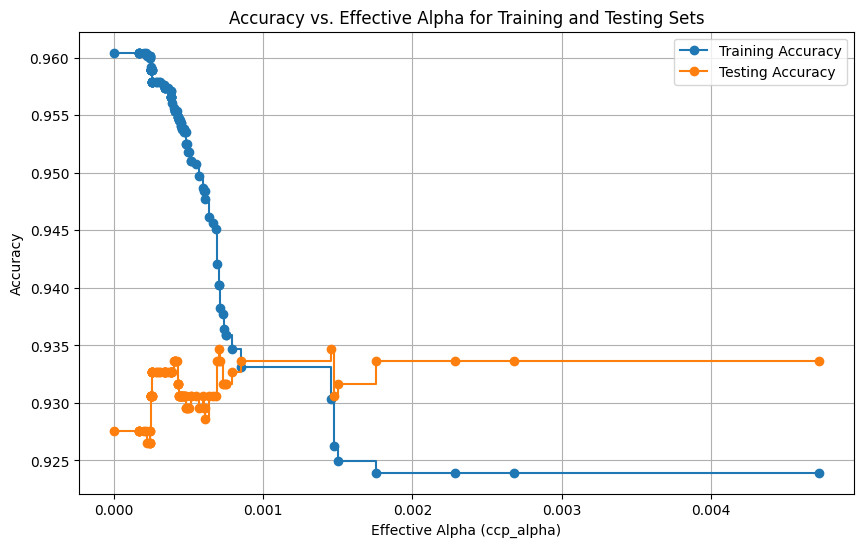

Optimal ccp_alpha: 0.0007038222964716062
Pruned Tree Accuracy: 0.9346938775510204

Pruned Tree Classification Report:
               precision    recall  f1-score   support

        High       0.50      0.17      0.26        35
         Low       0.60      0.10      0.17        30
      Medium       0.94      0.99      0.97       915

    accuracy                           0.93       980
   macro avg       0.68      0.42      0.46       980
weighted avg       0.92      0.93      0.92       980



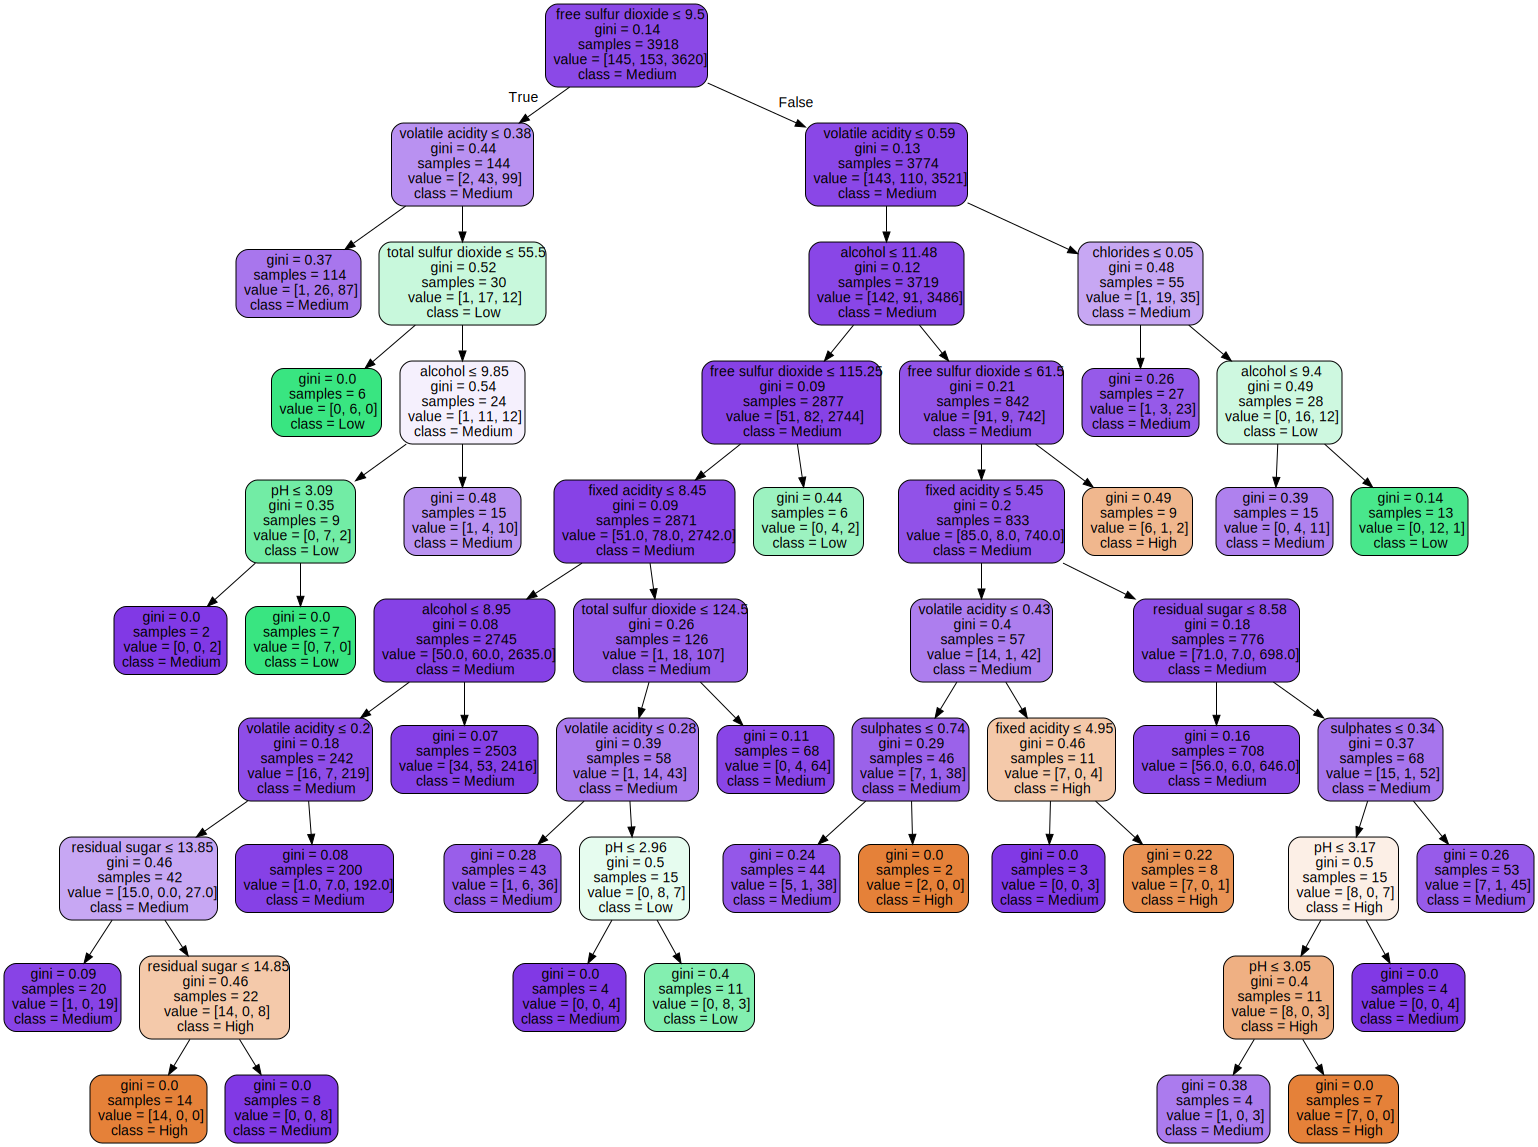

In [13]:
#grab the path total leaf impurities and then grab the alphas
path = DecisionTreeClassifier(random_state=42).cost_complexity_pruning_path(X_train, y_train)
ccp_alphas, impurities = path.ccp_alphas, path.impurities

clf_list = []

for ccp_alpha in ccp_alphas:
    Decision = DecisionTreeClassifier(max_depth=10,min_samples_leaf=1,min_samples_split=2 ,ccp_alpha = ccp_alpha, random_state=42)
    Decision.fit(X_train,y_train)
    clf_list.append(Decision)
    
train_scores = [clf.score(X_train, y_train) for clf in clf_list]
test_scores = [clf.score(X_test, y_test) for clf in clf_list]

plt.figure(figsize=(10, 6))
plt.plot(ccp_alphas, train_scores, marker='o', label='Training Accuracy', drawstyle="steps-post")
plt.plot(ccp_alphas, test_scores, marker='o', label='Testing Accuracy', drawstyle="steps-post")
plt.xlabel("Effective Alpha (ccp_alpha)")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Effective Alpha for Training and Testing Sets")
plt.legend()
plt.grid(True)
plt.show()

optimal_index = test_scores.index(max(test_scores))
optimal_alpha = ccp_alphas[optimal_index]
print(f"Optimal ccp_alpha: {optimal_alpha}")


pruned_tree = DecisionTreeClassifier(
    max_depth=10,
    min_samples_split=2,
    min_samples_leaf=1,
    ccp_alpha=optimal_alpha,
    random_state=42
)
pruned_tree.fit(X_train, y_train)

y_pred_pruned = pruned_tree.predict(X_test)

# Accuracy
accuracy_pruned = accuracy_score(y_test, y_pred_pruned)
print("Pruned Tree Accuracy:", accuracy_pruned)

# Classification Report
print("\nPruned Tree Classification Report:\n", classification_report(y_test, y_pred_pruned))


data_graph = tree.export_graphviz(
    pruned_tree, 
    out_file=None, 
    feature_names=X_train.columns,  
    class_names=[str(i) for i in sorted(y_train.unique())],  
    filled=True, 
    rounded=True,  
    special_characters=True,
    precision=2
)

# Generate the Graphviz visualization
graph = graphviz.Source(data_graph)
graph

In [14]:
from joblib import dump

# Save the pruned decision tree model
model_path = '../../../../models/pruned_decision_tree.joblib'
dump(pruned_tree, model_path)
print(f"Model saved to {model_path}")


Model saved to ../../../../models/pruned_decision_tree.joblib


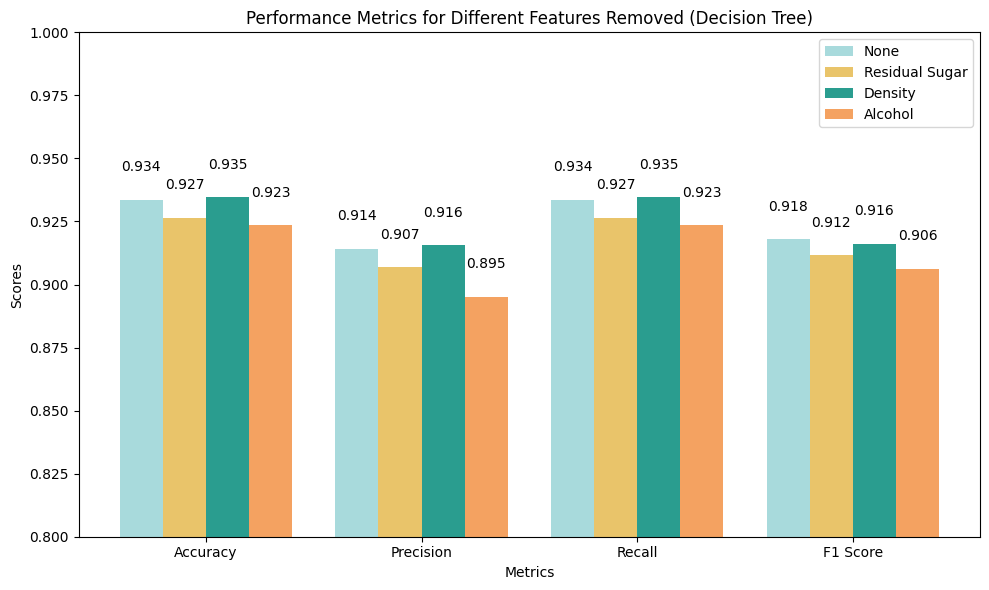

In [15]:
# Define features to test dropping
feature_combinations = {
    'None': [],
    'Residual Sugar': ['residual sugar'],
    'Density': ['density'],
    'Alcohol': ['alcohol']
}

# Dictionary to store metrics for each feature combination
metrics_scores = {name: [] for name in feature_combinations.keys()}

# For each feature combination
for name, features_to_drop in feature_combinations.items():
    # Load and preprocess data with specified features dropped
    X_train, X_test, y_train, y_test = load_and_preprocess_data(
        data_path, 
        features_to_drop=features_to_drop
    )
    
    # Train model with optimal parameters
    pruned_tree = DecisionTreeClassifier(
        max_depth=10,
        min_samples_split=2,
        min_samples_leaf=1,
        ccp_alpha=0.0007038222964716062,  # Using the optimal alpha from your previous run
        random_state=42
    )
    
    pruned_tree.fit(X_train, y_train)
    y_pred = pruned_tree.predict(X_test)
    
    # Calculate metrics
    metrics_scores[name].extend([
        accuracy_score(y_test, y_pred),
        precision_score(y_test, y_pred, average='weighted'),
        recall_score(y_test, y_pred, average='weighted'),
        f1_score(y_test, y_pred, average='weighted')
    ])

# Define colors
colors = ['#a8dadc',   # Light blue
          '#e9c46a',   # Muted yellow
          '#2a9d8f',   # Teal
          '#f4a261']   # Soft orange

# Create visualization
fig, ax = plt.subplots(figsize=(10, 6))

# Define metrics labels and positions
metric_labels = ['Accuracy', 'Precision', 'Recall', 'F1 Score']
x = np.arange(len(metric_labels))
width = 0.2

# Plot bars for each feature combination
for i, (feature, scores) in enumerate(metrics_scores.items()):
    offset = width * (i - len(metrics_scores)/2 + 0.5)
    bars = ax.bar(x + offset, scores, width, 
                 label=feature, color=colors[i])
    
    # Add value labels on top of bars
    for j, v in enumerate(scores):
        ax.text(x[j] + offset, v + 0.01, f'{v:.3f}', 
                ha='center', va='bottom', fontsize=10)

# Customize the plot
ax.set_xlabel('Metrics')
ax.set_ylabel('Scores')
ax.set_title('Performance Metrics for Different Features Removed (Decision Tree)')
ax.set_xticks(x)
ax.set_xticklabels(metric_labels)
ax.set_ylim(0.8, 1)  # Adjust as needed
ax.legend()

plt.tight_layout()
# Save the figure
plt.savefig('../../../data/eval_results/DT_features_removed.png', dpi=300, bbox_inches='tight')
plt.show()